In [1]:
from sklearn.model_selection import train_test_split
import numpy as np, cv2, pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T, models, datasets

import os
from glob import glob

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [3]:
if not os.path.exists('GTSRB'):
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

--2022-02-23 18:24:27--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2022-02-23 18:24:27 (28.3 MB/s) - ‘signnames.csv’ saved [999/999]



Assign class identifiers to potential output classes.

In [4]:
class_ids = pd.read_csv('signnames.csv')
class_ids.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [5]:
class_ids.set_index('ClassId', inplace=True)
class_ids = class_ids.to_dict()['SignName']
class_ids = {f'{class_id:05d}':sign_name
             for class_id, sign_name in class_ids.items()}
id2int = {sign_name:ix
          for ix, (class_id,sign_name) in enumerate(class_ids.items())}

Transformations without data augmentation

In [6]:
train_transformations = T.Compose([
                              T.ToPILImage(),
                              T.Resize(32),
                              T.CenterCrop(32),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
                        ])

val_transformations = T.Compose([
                            T.ToPILImage(),
                            T.Resize(32),
                            T.CenterCrop(32),
                            T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                      ])

Define the dataset and dataloaders

In [7]:
class GTSRB(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ix):
        file_path = self.files[ix]
        img_class = file_path.split("/")[-2]

        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img, class_ids[img_class]
    
    def choose(self):
        return self[np.random.randint(len(self))]
    
    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[img_class]])
                   for img_class in classes]
        
        imgs = torch.cat(imgs).to(device)
        classes = torch.cat(classes).to(device)

        return imgs, classes

In [8]:
all_files = glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

train_files, val_files = train_test_split(all_files, random_state=1)

train_dataset = GTSRB(train_files, transform=train_transformations)
val_dataset = GTSRB(val_files, transform=val_transformations)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                             collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                             collate_fn=val_dataset.collate_fn)

# Model

In [9]:
class SignClassifier(nn.Module):
    def __init__(self, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm

        self.model = nn.Sequential(
                        self.conv_block(3, 64),
                        self.conv_block(64, 64),
                        self.conv_block(64, 128),
                        self.conv_block(128, 64),
                        nn.Flatten(),
                        nn.Linear(256, 256),
                        nn.Dropout(0.2),
                        nn.ReLU(inplace=True),
                        nn.Linear(256, len(id2int))
                     )
        self.loss_fn = nn.CrossEntropyLoss()


    def conv_block(self, in_channels, out_channels):
        if self.batch_norm:
            return nn.Sequential(
                nn.Dropout(0.2),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(kernel_size=2),
            )
        else:
            return nn.Sequential(
                nn.Dropout(0.2),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
            )


    def forward(self, x):
        return self.model(x)
    

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        accuracy = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, accuracy

# Functions

In [10]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    images, labels = data
    preds = model(images)
    loss, accuracy = criterion(preds, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), accuracy.item()

In [11]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, labels = data
    preds = model(images)
    loss, accuracy = criterion(preds, labels)
    return loss.item(), accuracy.item()

# Train without data augmentation and without batch norm

In [12]:
accuracies = {
    'Without Augmentation - Without Batch Normalization': {
        "train": [],
        "val": []
    },
    'Without Augmentation - With Batch Normalization': {
        "train": [],
        "val": []
    },
    'With Augmentation - With Batch Normalization': {
        "train": [],
        "val": []
    }
}

In [13]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

In [14]:
for epoch in range(1, n_epochs + 1):
    train_epoch_losses, train_epoch_accuracies = [], []
    for batch in train_dataloader:
        loss, accuracy = train_batch(model, batch, optimizer, criterion)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(accuracy)
    
    val_epoch_losses, val_epoch_accuracies = [], []
    for batch in val_dataloader:
        loss, accuracy = validate_batch(model, batch, criterion)
        val_epoch_losses.append(loss)
        val_epoch_accuracies.append(accuracy)
    
    train_accuracy = np.mean(train_epoch_accuracies)
    val_accuracy = np.mean(val_epoch_accuracies)
    
    accuracies['Without Augmentation - Without Batch Normalization']\
              ['train'].append(train_accuracy)
    accuracies['Without Augmentation - Without Batch Normalization']\
              ['val'].append(val_accuracy)

    print(f"EPOCH: {epoch}\t"
          f"train_loss: {np.mean(train_epoch_losses):.2f}\t"
          f"train_accuracy: {train_accuracy:.2f}\t"
          f"val_loss: {np.mean(val_epoch_losses):.2f}\t"
          f"val_accuracy: {val_accuracy:.2f}")

EPOCH: 1	train_loss: 2.35	train_accuracy: 0.31	val_loss: 1.41	val_accuracy: 0.54
EPOCH: 2	train_loss: 1.02	train_accuracy: 0.66	val_loss: 0.80	val_accuracy: 0.78
EPOCH: 3	train_loss: 0.66	train_accuracy: 0.78	val_loss: 0.72	val_accuracy: 0.79
EPOCH: 4	train_loss: 0.53	train_accuracy: 0.82	val_loss: 0.80	val_accuracy: 0.78
EPOCH: 5	train_loss: 0.45	train_accuracy: 0.85	val_loss: 0.64	val_accuracy: 0.82
EPOCH: 6	train_loss: 0.40	train_accuracy: 0.87	val_loss: 0.51	val_accuracy: 0.85
EPOCH: 7	train_loss: 0.38	train_accuracy: 0.88	val_loss: 0.74	val_accuracy: 0.80
EPOCH: 8	train_loss: 0.35	train_accuracy: 0.89	val_loss: 0.66	val_accuracy: 0.81
EPOCH: 9	train_loss: 0.32	train_accuracy: 0.89	val_loss: 0.65	val_accuracy: 0.82
EPOCH: 10	train_loss: 0.31	train_accuracy: 0.90	val_loss: 0.53	val_accuracy: 0.86
EPOCH: 11	train_loss: 0.30	train_accuracy: 0.90	val_loss: 0.47	val_accuracy: 0.86
EPOCH: 12	train_loss: 0.28	train_accuracy: 0.91	val_loss: 0.64	val_accuracy: 0.82
EPOCH: 13	train_loss: 0.2

# Train without data augmentation and with batch norm

In [15]:
model = SignClassifier(batch_norm=True).to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

In [16]:
for epoch in range(1, n_epochs + 1):
    train_epoch_losses, train_epoch_accuracies = [], []
    for batch in train_dataloader:
        loss, accuracy = train_batch(model, batch, optimizer, criterion)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(accuracy)
    
    val_epoch_losses, val_epoch_accuracies = [], []
    for batch in val_dataloader:
        loss, accuracy = validate_batch(model, batch, criterion)
        val_epoch_losses.append(loss)
        val_epoch_accuracies.append(accuracy)
    
    train_accuracy = np.mean(train_epoch_accuracies)
    val_accuracy = np.mean(val_epoch_accuracies)
    
    accuracies['Without Augmentation - With Batch Normalization']\
              ['train'].append(train_accuracy)
    accuracies['Without Augmentation - With Batch Normalization']\
              ['val'].append(val_accuracy)

    print(f"EPOCH: {epoch}\t"
          f"train_loss: {np.mean(train_epoch_losses):.2f}\t"
          f"train_accuracy: {train_accuracy:.2f}\t"
          f"val_loss: {np.mean(val_epoch_losses):.2f}\t"
          f"val_accuracy: {val_accuracy:.2f}")

EPOCH: 1	train_loss: 1.37	train_accuracy: 0.59	val_loss: 1.08	val_accuracy: 0.70
EPOCH: 2	train_loss: 0.43	train_accuracy: 0.86	val_loss: 0.41	val_accuracy: 0.87
EPOCH: 3	train_loss: 0.29	train_accuracy: 0.91	val_loss: 0.88	val_accuracy: 0.79
EPOCH: 4	train_loss: 0.23	train_accuracy: 0.92	val_loss: 0.51	val_accuracy: 0.85
EPOCH: 5	train_loss: 0.19	train_accuracy: 0.94	val_loss: 0.31	val_accuracy: 0.90
EPOCH: 6	train_loss: 0.17	train_accuracy: 0.94	val_loss: 0.45	val_accuracy: 0.87
EPOCH: 7	train_loss: 0.14	train_accuracy: 0.95	val_loss: 0.48	val_accuracy: 0.88
EPOCH: 8	train_loss: 0.13	train_accuracy: 0.96	val_loss: 0.34	val_accuracy: 0.91
EPOCH: 9	train_loss: 0.12	train_accuracy: 0.96	val_loss: 0.76	val_accuracy: 0.83
EPOCH: 10	train_loss: 0.11	train_accuracy: 0.96	val_loss: 0.46	val_accuracy: 0.88
EPOCH: 11	train_loss: 0.10	train_accuracy: 0.97	val_loss: 0.29	val_accuracy: 0.92
EPOCH: 12	train_loss: 0.10	train_accuracy: 0.97	val_loss: 0.42	val_accuracy: 0.89
EPOCH: 13	train_loss: 0.0

# Train with data augmentation and with batch norm

In [17]:
train_transformations = T.Compose([
                              T.ToPILImage(),
                              T.Resize(32),
                              T.CenterCrop(32),
                              T.ColorJitter(
                                            brightness=(0.8, 1.2),
                                            contrast=(0.8, 1.2),
                                            saturation=(0.8, 1.2),
                                            hue=0.25
                                            ),
                              T.RandomAffine(5, translate=(0.01, 0.1)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
                        ])

train_dataset = GTSRB(train_files, transform=train_transformations)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                             collate_fn=train_dataset.collate_fn)

In [18]:
model = SignClassifier(batch_norm=True).to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

In [19]:
for epoch in range(1, n_epochs + 1):
    train_epoch_losses, train_epoch_accuracies = [], []
    for batch in train_dataloader:
        loss, accuracy = train_batch(model, batch, optimizer, criterion)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(accuracy)
    
    val_epoch_losses, val_epoch_accuracies = [], []
    for batch in val_dataloader:
        loss, accuracy = validate_batch(model, batch, criterion)
        val_epoch_losses.append(loss)
        val_epoch_accuracies.append(accuracy)
    
    train_accuracy = np.mean(train_epoch_accuracies)
    val_accuracy = np.mean(val_epoch_accuracies)
    
    accuracies['With Augmentation - With Batch Normalization']\
              ['train'].append(train_accuracy)
    accuracies['With Augmentation - With Batch Normalization']\
              ['val'].append(val_accuracy)

    print(f"EPOCH: {epoch}\t"
          f"train_loss: {np.mean(train_epoch_losses):.2f}\t"
          f"train_accuracy: {train_accuracy:.2f}\t"
          f"val_loss: {np.mean(val_epoch_losses):.2f}\t"
          f"val_accuracy: {val_accuracy:.2f}")

EPOCH: 1	train_loss: 1.86	train_accuracy: 0.46	val_loss: 0.98	val_accuracy: 0.71
EPOCH: 2	train_loss: 0.70	train_accuracy: 0.77	val_loss: 0.76	val_accuracy: 0.79
EPOCH: 3	train_loss: 0.50	train_accuracy: 0.84	val_loss: 0.33	val_accuracy: 0.90
EPOCH: 4	train_loss: 0.40	train_accuracy: 0.87	val_loss: 0.46	val_accuracy: 0.87
EPOCH: 5	train_loss: 0.34	train_accuracy: 0.89	val_loss: 0.51	val_accuracy: 0.86
EPOCH: 6	train_loss: 0.29	train_accuracy: 0.90	val_loss: 0.30	val_accuracy: 0.92
EPOCH: 7	train_loss: 0.27	train_accuracy: 0.91	val_loss: 0.55	val_accuracy: 0.86
EPOCH: 8	train_loss: 0.24	train_accuracy: 0.92	val_loss: 0.22	val_accuracy: 0.94
EPOCH: 9	train_loss: 0.23	train_accuracy: 0.92	val_loss: 0.25	val_accuracy: 0.92
EPOCH: 10	train_loss: 0.21	train_accuracy: 0.93	val_loss: 0.25	val_accuracy: 0.93
EPOCH: 11	train_loss: 0.20	train_accuracy: 0.93	val_loss: 0.30	val_accuracy: 0.92
EPOCH: 12	train_loss: 0.19	train_accuracy: 0.94	val_loss: 0.21	val_accuracy: 0.94
EPOCH: 13	train_loss: 0.1

# Compare the result

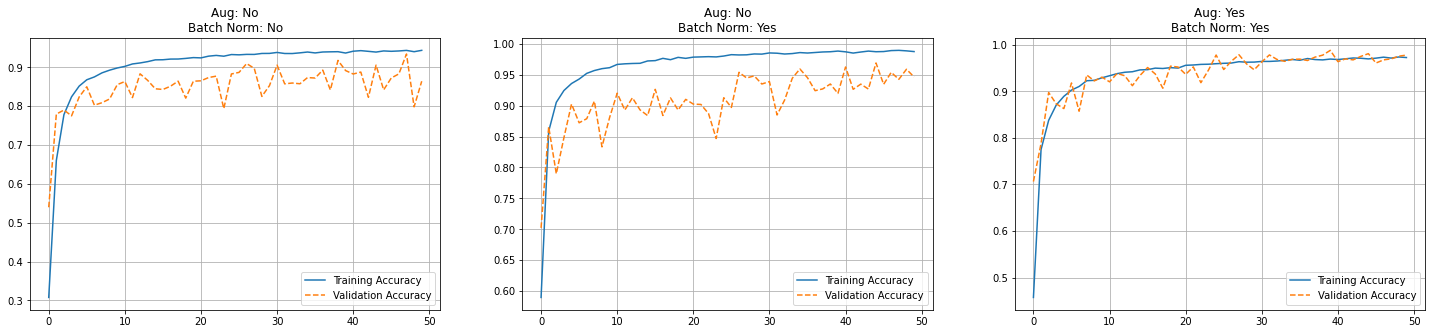

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

ax[0].plot(accuracies['Without Augmentation - Without Batch Normalization']['train'])
ax[0].plot(accuracies['Without Augmentation - Without Batch Normalization']['val'],
           linestyle='dashed')
ax[0].grid(True)
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set(title="Aug: No\nBatch Norm: No")

ax[1].plot(accuracies['Without Augmentation - With Batch Normalization']['train'])
ax[1].plot(accuracies['Without Augmentation - With Batch Normalization']['val'],
           linestyle='dashed')
ax[1].grid(True)
ax[1].legend(['Training Accuracy', 'Validation Accuracy'])
ax[1].set(title="Aug: No\nBatch Norm: Yes")

ax[2].plot(accuracies['With Augmentation - With Batch Normalization']['train'])
ax[2].plot(accuracies['With Augmentation - With Batch Normalization']['val'],
           linestyle='dashed')
ax[2].grid(True)
ax[2].legend(['Training Accuracy', 'Validation Accuracy'])
ax[2].set(title="Aug: Yes\nBatch Norm: Yes");

# Conclusion
While utilizing batch normalization boosts the model's accuracy considerably, it still suffers from overfitting. By implementing data augmentation in addition we can tackle the overfitting problem.